# 1D power spectrum LLS

In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

## Read the data from both files

In [2]:
# specify the path to the two files with Lyman alpha skewers, with (ON) and without (OFF) self-shielding 
fname_off='/data/desi/common/astrid/spectra_ASTRID_self-shield_off_z2.5_500x500x2500.hdf5'
fname_on='/data/desi/common/astrid/spectra_ASTRID_z2.5_500x500x2500.hdf5'

In [3]:
with h5py.File(fname_on,'r') as f:
    tau_on = f['tau/H/1/1215'][:]
    colden = f['colden']['H/1'][:]
    axes = f['spectra/axes'][:]
    # (x,y,z) start of the skewers, in kpc/h
    cofm_hkpc = f['spectra/cofm'][:]

In [4]:
with h5py.File(fname_off,'r') as f:
    tau_off = f['tau/H/1/1215'][:]
    # column densities were not stored for this file (should be the same as in the other file)
    #colden_off = f['colden']['H/1'][:]
    axes_off = f['spectra/axes'][:]
    cofm_off = f['spectra/cofm'][:]

In [5]:
# box lenght in Mpc/h
# this information should be stored in the HDF5, but I couldn't find it... so added it by hand
L_hMpc=250
# number of skewers per side (500)
Nsk=int(np.sqrt(colden.shape[0]))
print(Nsk,'skewers per side')
# number of pixels / cells per skewer (2500)
Np=int(colden.shape[1])
print(Np,'pixels per skewer')
# pixel width (in Mpc/h)
dz_hMpc=L_hMpc/Np
print('pixel width = {:.3f} Mpc/h'.format(dz_hMpc))

500 skewers per side
2500 pixels per skewer
pixel width = 0.100 Mpc/h


## Keep only skewers with Lya and LLS

In [6]:
# maximum column density at a given line of sight
max_logN_in_sk = np.log10(np.max(colden.reshape([Nsk,Nsk,Np]),axis=2)).flatten()

In [7]:
# let's get rid of all lines of sight with a DLA larger than 21.3
max_logN_mask_LLS = 19
mask_sk_LLS = (max_logN_in_sk > max_logN_mask_LLS)
print('{} skewers are masked, {:.4f} %'.format(np.sum(mask_sk_LLS), 100*np.sum(mask_sk_LLS)/(Nsk**2)))

55963 skewers are masked, 22.3852 %


In [8]:
new_skwrs_LLS = np.where(~mask_sk_LLS)[0] #the symbol ~ inverts the boolean type

In [9]:
# we keep only the optical depth corresponding to reasonable skewers
new_tau_on_LLS = tau_on[new_skwrs_LLS]
new_tau_off_LLS = tau_off[new_skwrs_LLS]

## Define the fields with and without HCDs

In [10]:
# this will be used as the total optical depth
tau_max_LLS = np.fmax(new_tau_on_LLS, new_tau_off_LLS)

In [11]:
# this will be used as a first guess of HCD contamination
tau_LLS = tau_max_LLS - new_tau_off_LLS
# that will then be smoothed
tau_modes = np.fft.rfft(tau_LLS)
k = np.fft.rfftfreq(Np)*2*np.pi/dz_hMpc
r_hMpc=0.3
tau_LLS = np.fft.irfft(tau_modes * np.exp(-(r_hMpc*k)**2))

In [12]:
# this will be used as the Lya optical depth 
tau_lya = new_tau_off_LLS
# this will be the total optical depth
tau_tot = tau_lya + tau_LLS

In [14]:
np.save('/data/desi/scratch/jlopez/tau_tot.npy', tau_tot)
np.save('/data/desi/scratch/jlopez/tau_lya.npy', tau_lya)
np.save('/data/desi/scratch/jlopez/tau_LLS.npy', tau_LLS)

### Checkpoint 1

In [1]:
import numpy as np

In [2]:
tau_tot = np.load('/data/desi/scratch/jlopez/tau_tot.npy')

In [2]:
tau_lya = np.load('/data/desi/scratch/jlopez/tau_lya.npy')

In [3]:
tau_LLS = np.load('/data/desi/scratch/jlopez/tau_LLS.npy')

## Calculate the one dimensional power spectrum

### Field of the Lymann-alpha forest

In [5]:
flux_lya = np.exp(-tau_lya)
avg_lya = np.mean(flux_lya)
np.save('/data/desi/scratch/jlopez/avg_lya.npy', avg_lya)

In [6]:
delta_flux_lya = flux_lya / avg_lya - 1

In [7]:
fft_lya = np.fft.fft(delta_flux_lya)
np.save('/data/desi/scratch/jlopez/fft_lya.npy', fft_lya)

### Field of the high column density systems

In [3]:
flux_LLS = np.exp(-tau_LLS)
avg_LLS = np.mean(flux_LLS)
np.save('/data/desi/scratch/jlopez/avg_LLS.npy', avg_LLS)

In [4]:
delta_flux_LLS = flux_LLS / avg_LLS - 1

In [5]:
fft_LLS = np.fft.fft(delta_flux_LLS)
np.save('/data/desi/scratch/jlopez/fft_LLS.npy', fft_LLS)

### Product of the fields

In [4]:
flux_lya = np.exp(-tau_lya)
avg_lya = np.mean(flux_lya)
flux_LLS = np.exp(-tau_LLS)
avg_LLS = np.mean(flux_LLS)
delta_flux_lya = flux_lya / avg_lya - 1
delta_flux_LLS = flux_LLS / avg_LLS - 1

In [5]:
# We have to compute the product in real space
delta_flux_lyaLLS = delta_flux_lya * delta_flux_LLS

In [6]:
fft_lyaLLS = np.fft.fft(delta_flux_lyaLLS)
np.save('/data/desi/scratch/jlopez/fft_lyaLLS.npy', fft_lyaLLS)

### Field of every skewer

In [3]:
flux_tot = np.exp(-tau_tot)
avg_tot = np.mean(flux_tot)
delta_flux_tot = flux_tot / avg_tot - 1
np.save('/data/desi/scratch/jlopez/avg_tot.npy', avg_tot)

In [4]:
fft_tot = np.fft.fft(delta_flux_tot)
np.save('/data/desi/scratch/jlopez/fft_tot.npy', fft_tot)

### Checkpoint 2

In [1]:
import numpy as np

In [2]:
avg_lya = np.load('/data/desi/scratch/jlopez/avg_lya.npy')
avg_LLS = np.load('/data/desi/scratch/jlopez/avg_LLS.npy')
avg_tot = np.load('/data/desi/scratch/jlopez/avg_tot.npy')

In [10]:
fft_lya = np.load('/data/desi/scratch/jlopez/fft_lya.npy')

In [11]:
fft_LLS = np.load('/data/desi/scratch/jlopez/fft_LLS.npy')

In [5]:
fft_tot = np.load('/data/desi/scratch/jlopez/fft_tot.npy')

In [2]:
fft_lyaLLS = np.load('/data/desi/scratch/jlopez/fft_lyaLLS.npy')

## Calculate 1D correlations

In [4]:
C = avg_tot / (avg_lya * avg_LLS) - 1

In [3]:
Np = 2500

In [9]:
tot = fft_tot * fft_tot.conj() / Np
P_F = np.mean(tot, axis=0)
np.save('/data/desi/scratch/jlopez/P_F.npy', P_F)

In [10]:
a = fft_lya * fft_lya.conj() / Np
P_a = np.mean(a, axis=0)
np.save('/data/desi/scratch/jlopez/P_a.npy', P_a)

In [4]:
L = fft_LLS * fft_LLS.conj() / Np
P_L = np.mean(L, axis=0)
np.save('/data/desi/scratch/jlopez/P_L.npy', P_L)

In [12]:
aL = (fft_lya * fft_LLS.conj() + fft_LLS * fft_lya.conj()) / Np
P_aL = np.mean(aL, axis=0)
np.save('/data/desi/scratch/jlopez/P_aL.npy', P_aL)

In [5]:
a3 = (fft_lyaLLS * fft_lya.conj() + fft_lyaLLS.conj() * fft_lya)/ Np
P_a3 = np.mean(a3, axis=0)
np.save('/data/desi/scratch/jlopez/P_a3.npy', P_a3)

In [5]:
L3 = (fft_lyaLLS * fft_LLS.conj() + fft_lyaLLS.conj() * fft_LLS) / Np
P_L3 = np.mean(L3, axis=0)
np.save('/data/desi/scratch/jlopez/P_L3.npy', P_L3)

In [4]:
p4 = fft_lyaLLS * fft_lyaLLS.conj() / Np
P_p4 = np.mean(p4, axis=0)
np.save('/data/desi/scratch/jlopez/P_p4.npy', P_p4)

### Checkpoint 3

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [5]:
Np = 2500

In [6]:
k = 2*np.pi/250*np.arange(Np)

In [7]:
P_F = np.load('/data/desi/scratch/jlopez/P_F.npy')

In [8]:
P_a = np.load('/data/desi/scratch/jlopez/P_a.npy')

In [9]:
P_L = np.load('/data/desi/scratch/jlopez/P_L.npy')

In [10]:
P_aL = np.load('/data/desi/scratch/jlopez/P_aL.npy')

In [11]:
P_L3 = np.load('/data/desi/scratch/jlopez/P_L3.npy')

In [12]:
P_a3 = np.load('/data/desi/scratch/jlopez/P_a3.npy')

In [13]:
P_p4 = np.load('/data/desi/scratch/jlopez/P_p4.npy')

In [14]:
'''
plt.plot(k, P_F.real, label = r'$P^{1D}_{F}$')
plt.plot(k, P_a.real, label = r'$P^{1D}_{\alpha}$')
plt.plot(k, P_H.real, label = r'$P^{1D}_{H}$')
plt.plot(k, P_aH.real, label = r'$P^{1D}_{\alpha H}$')
plt.plot(k, P_H3.real, label = r'$P^{1D}_{3H}$')
plt.plot(k, P_a3.real, label = r'$P^{1D}_{3\alpha}$')
plt.plot(k, P_p4.real, label = r'$P^{1D}_{4}$')
plt.xlim(k[1], 10)
plt.xscale("log")
plt.ylim(1e-8,1e6)
plt.yscale('log')
plt.legend()
plt.title('P1D')
plt.show()
'''

'\nplt.plot(k, P_F.real, label = r\'$P^{1D}_{F}$\')\nplt.plot(k, P_a.real, label = r\'$P^{1D}_{\x07lpha}$\')\nplt.plot(k, P_H.real, label = r\'$P^{1D}_{H}$\')\nplt.plot(k, P_aH.real, label = r\'$P^{1D}_{\x07lpha H}$\')\nplt.plot(k, P_H3.real, label = r\'$P^{1D}_{3H}$\')\nplt.plot(k, P_a3.real, label = r\'$P^{1D}_{3\x07lpha}$\')\nplt.plot(k, P_p4.real, label = r\'$P^{1D}_{4}$\')\nplt.xlim(k[1], 10)\nplt.xscale("log")\nplt.ylim(1e-8,1e6)\nplt.yscale(\'log\')\nplt.legend()\nplt.title(\'P1D\')\nplt.show()\n'

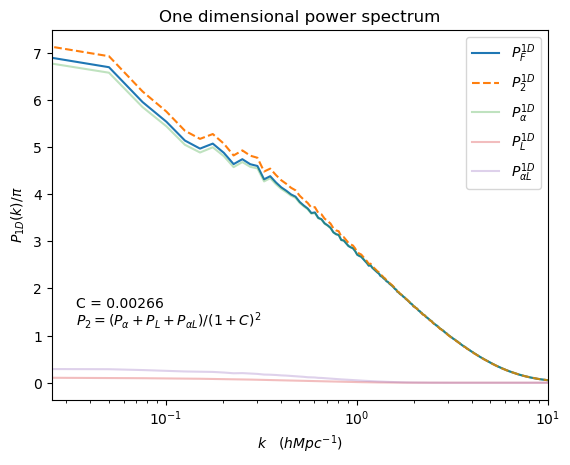

In [40]:
plt.plot(k, P_F.real, label = r'$P^{1D}_{F}$')
plt.plot(k, (1 + C)**(-2) * (P_a.real + P_L.real + P_aL.real - C**2), label = r'$P^{1D}_{2}$', linestyle = '--')
plt.plot(k, P_a.real, label = r'$P^{1D}_{\alpha}$', alpha = 0.3)
plt.plot(k, P_L.real, label = r'$P^{1D}_{L}$', alpha = 0.3)
plt.plot(k, P_aL.real, label = r'$P^{1D}_{\alpha L}$', alpha = 0.3)
plt.xlim(k[1], 10)
plt.xscale("log")
plt.legend()
plt.title('One dimensional power spectrum')
plt.xlabel(r"$k\quad (hMpc^{-1})$")
plt.ylabel(r"$P_{1D}(k)/\pi $")
plt.text(0.05, 0.25, 'C = {:.5f}'.format(C), transform = plt.gca().transAxes, fontsize=10)
plt.text(0.05, 0.2, r'$P_{2}=(P_{\alpha}+P_{L}+P_{\alpha L})/(1+C)^2$', transform = plt.gca().transAxes, fontsize=10)
plt.savefig('P1D_LLS')
plt.show()

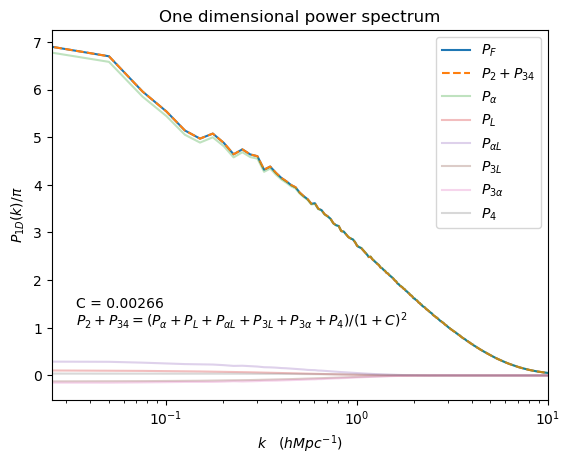

In [42]:
plt.plot(k, P_F.real, label = r'$P_{F}$')
plt.plot(k, (1 + C)**(-2) * (P_a.real + P_L.real + P_aL.real +  P_L3.real + P_a3.real + P_p4.real), label = r'$P_{2}+P_{34}$', linestyle = '--')
plt.plot(k, P_a.real, label = r'$P_{\alpha}$', alpha = 0.3)
plt.plot(k, P_L.real, label = r'$P_{L}$', alpha = 0.3)
plt.plot(k, P_aL.real, label = r'$P_{\alpha L}$', alpha = 0.3)
plt.plot(k, P_L3.real, label = r'$P_{3L}$', alpha = 0.3)
plt.plot(k, P_a3.real, label = r'$P_{3\alpha}$', alpha = 0.3)
plt.plot(k, P_p4.real, label = r'$P_{4}$', alpha = 0.3)
plt.xlim(k[1], 10)
plt.xscale("log")
plt.legend()
plt.title('One dimensional power spectrum')
plt.xlabel(r"$k\quad (hMpc^{-1})$")
plt.ylabel(r"$P_{1D}(k)/\pi $")
plt.text(0.05, 0.25, 'C = {:.5f}'.format(C), transform = plt.gca().transAxes, fontsize=10)
plt.text(0.05, 0.2, r'$P_{2}+P_{34}=(P_{\alpha}+P_{L}+P_{\alpha L}+P_{3L}+P_{3\alpha}+P_{4})/(1+C)^2$', transform = plt.gca().transAxes, fontsize=10)
plt.savefig('P1D_3p_LLS')
plt.show()

In [36]:
P_2 = (P_a + P_aL + P_L) / (1 + C)**2
P_34 = (P_a3 + P_L3 + P_p4) / (1 + C)**2

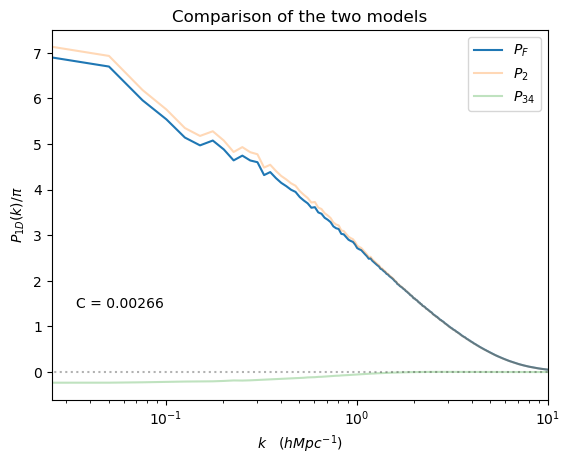

In [38]:

plt.plot(k, P_F.real, label = r'$P_{F}$')
plt.plot(k, P_2.real, label = r'$P_{2}$', alpha = 0.3)
plt.plot(k, P_34.real, label = r'$P_{34}$', alpha = 0.3)
plt.plot(k,k[:]*0,"k:", alpha = 0.3)
plt.xlim(k[1], 10)
plt.xscale("log")
#plt.ylim(0.05,50)
#plt.yscale('log')
plt.legend()
plt.title('Comparison of the two models')
plt.xlabel(r"$k\quad (hMpc^{-1})$")
plt.ylabel(r"$P_{1D}(k)/\pi $")
plt.text(0.05, 0.25, 'C = {:.5f}'.format(C), transform = plt.gca().transAxes, fontsize=10)

plt.savefig('Compare_models')
plt.show()


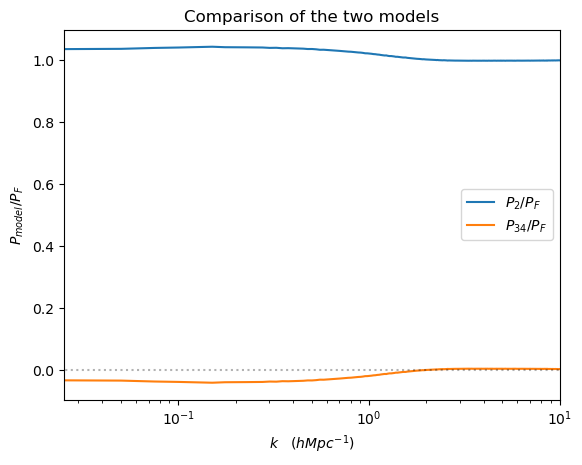

In [46]:

plt.plot(k, P_2.real / P_F.real, label = r'$P_{2}/P_{F}$')
plt.plot(k, P_34.real / P_F.real, label = r'$P_{34}/P_{F}$')
plt.plot(k,k[:]*0,"k:", alpha = 0.3)
plt.xlim(k[1], 10)
plt.xscale("log")
plt.legend()
plt.title('Comparison of the two models')
plt.xlabel(r"$k\quad (hMpc^{-1})$")
plt.ylabel(r"$P_{model}/P_F $")
#plt.text(0.05, 0.25, 'C = {:.5f}'.format(C), transform = plt.gca().transAxes, fontsize=10)
plt.savefig('Ratio_models')
plt.show()
